#### Imports

In [1]:
!cd C:\Users\tulio\Downloads\vitao\1%Ru used\Photocurrent\Light Intensity

In [2]:
from functions import *

import sys
import re
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d # <-- NEW: Import the filter
from scipy.optimize import curve_fit


#### Paths

In [3]:
folder_path = r'C:\Users\tulio\Downloads\vitao\1%Ru used\Photocurrent\Light Intensity'

# Define the path to the folder you want to create
# saving_path = 'analysis_results'

# # Create the directory. If it already exists, nothing happens.
# os.makedirs(saving_path, exist_ok=True)

# print(f"Folder '{saving_path}' is ready")

#### Load pre process

In [4]:
desired_potentials = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
tables = load_dta_folder(folder_path,verbose=False)
data_by_potential = group_by_potential(tables, desired_potentials=desired_potentials,verbose=False)

#### Plots


Processing: 100 mW/cm²
225
--- Individual Plots for 100 mW/cm² (Avg: 0.039 µA) ---


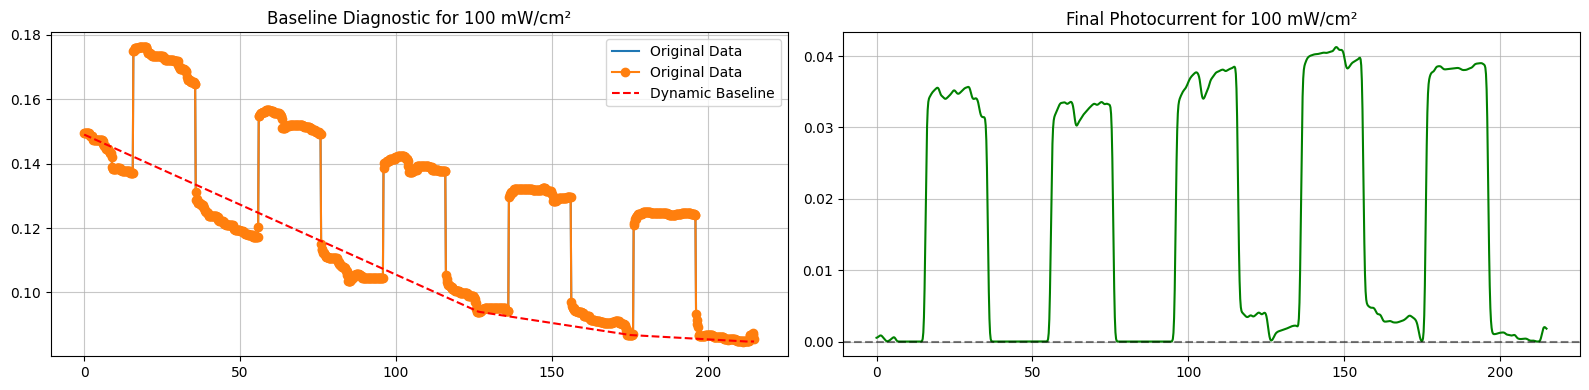


Processing: 200 mW/cm²
225
--- Individual Plots for 200 mW/cm² (Avg: 0.054 µA) ---


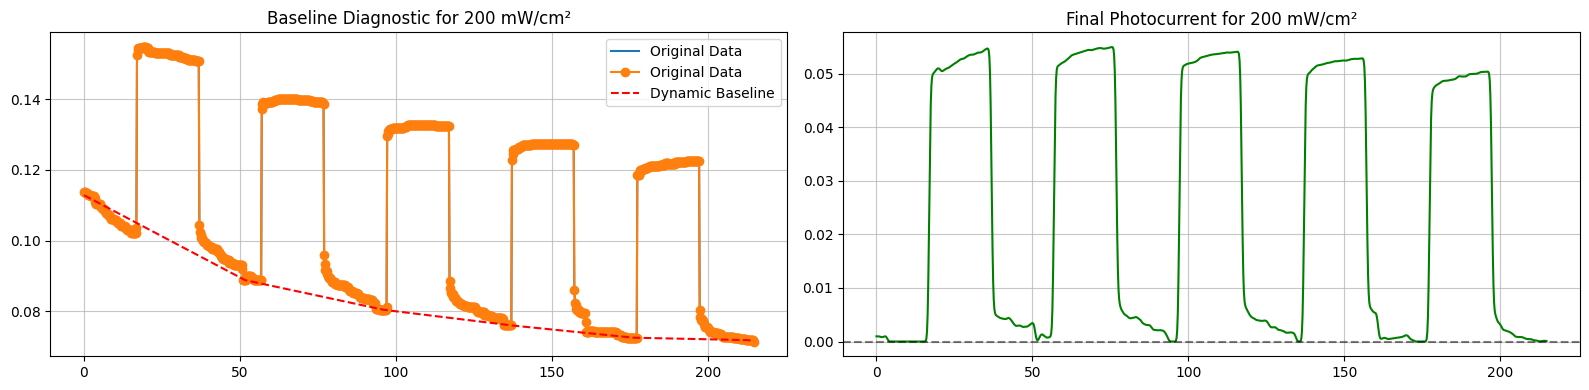


Processing: 300 mW/cm²
225
--- Individual Plots for 300 mW/cm² (Avg: 0.060 µA) ---


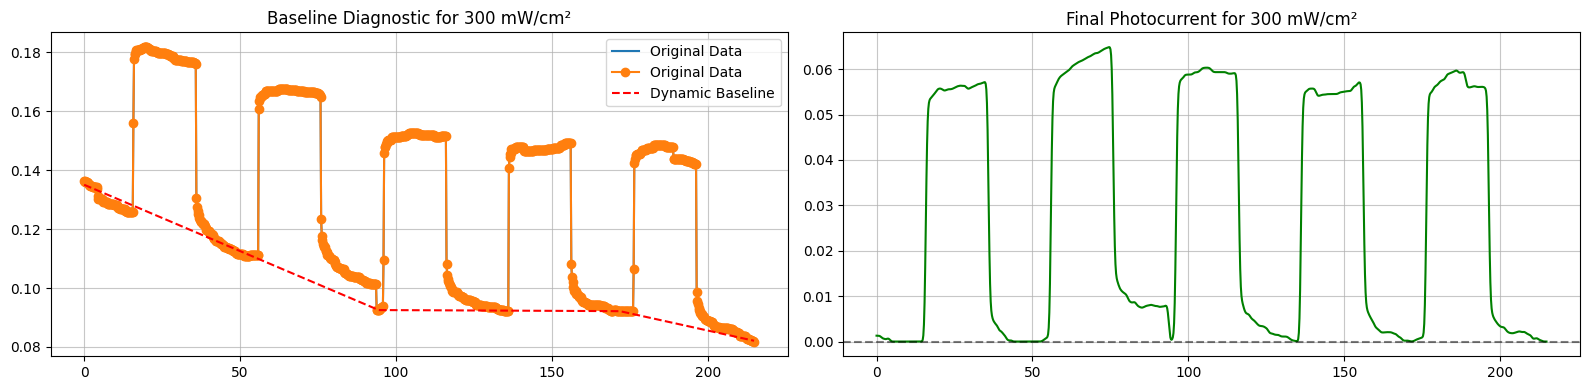


Processing: 400 mW/cm²
225
--- Individual Plots for 400 mW/cm² (Avg: 0.076 µA) ---


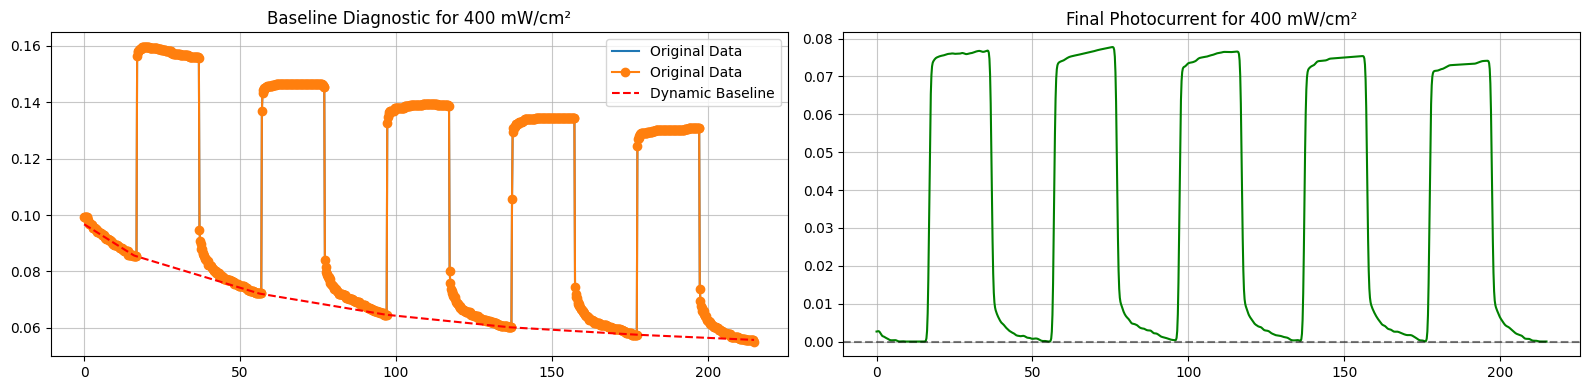


Processing: 500 mW/cm²
225
--- Individual Plots for 500 mW/cm² (Avg: 0.090 µA) ---


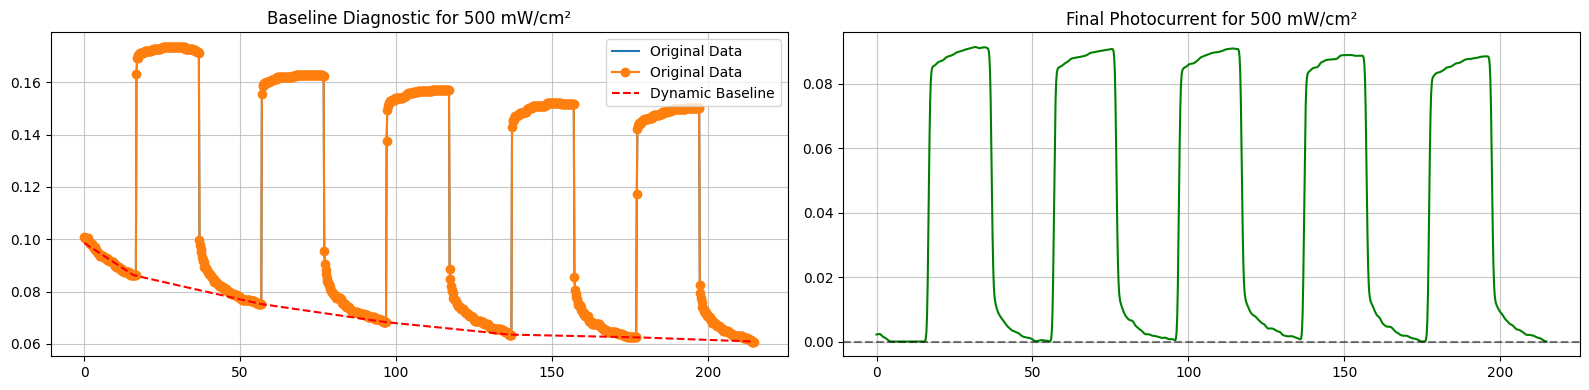


Processing: 600 mW/cm²
225
--- Individual Plots for 600 mW/cm² (Avg: 0.106 µA) ---


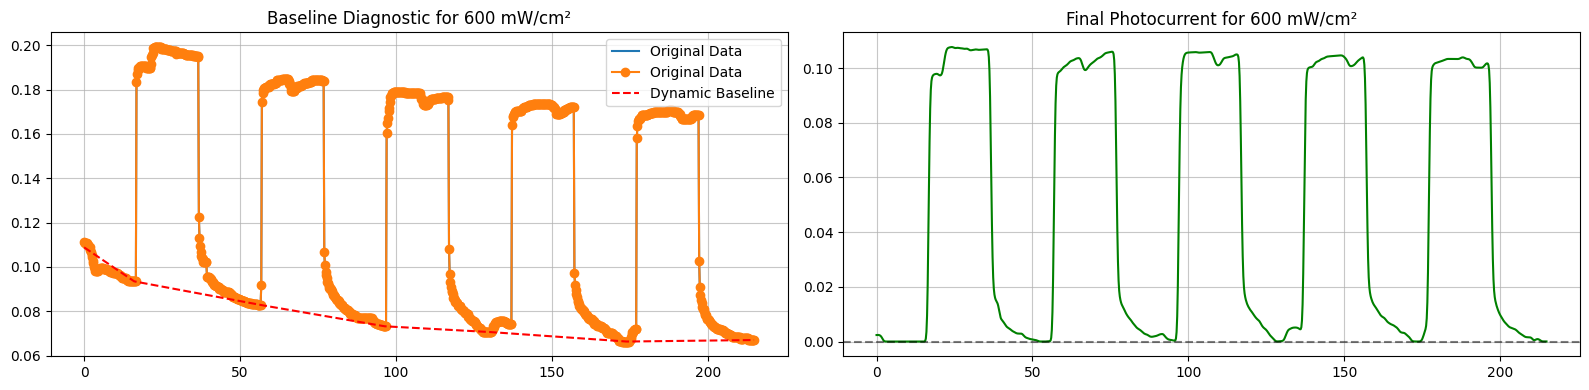


Processing: 700 mW/cm²
225
--- Individual Plots for 700 mW/cm² (Avg: 0.121 µA) ---


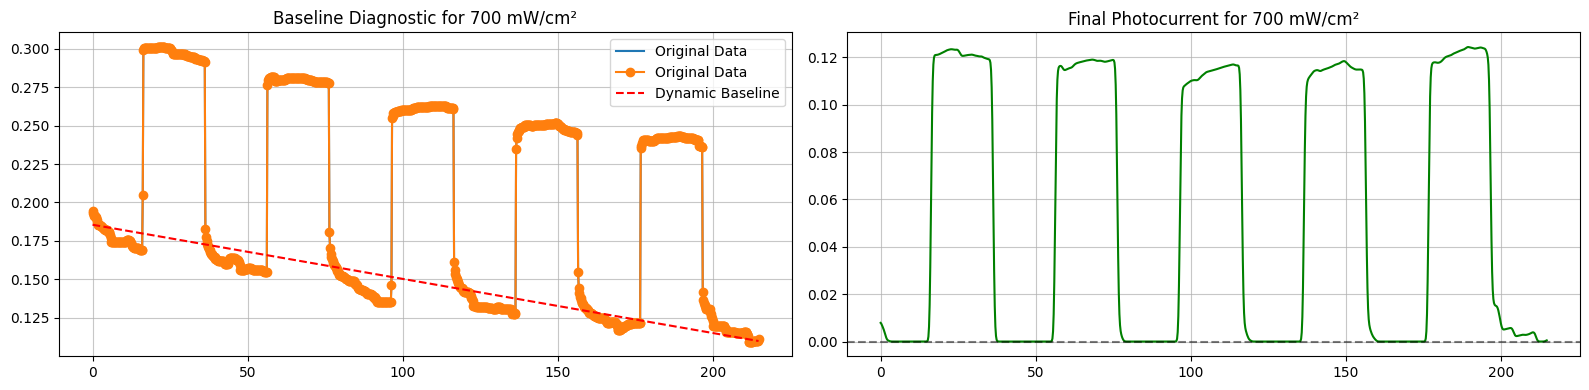


Processing: 800 mW/cm²
225
--- Individual Plots for 800 mW/cm² (Avg: 0.156 µA) ---


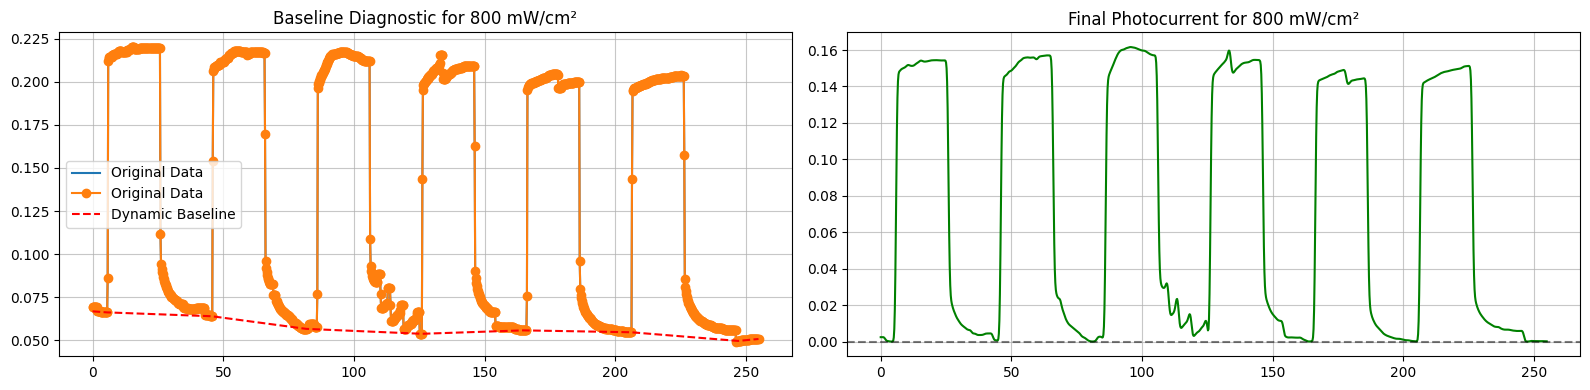


Processing: 900 mW/cm²
225
--- Individual Plots for 900 mW/cm² (Avg: 0.193 µA) ---


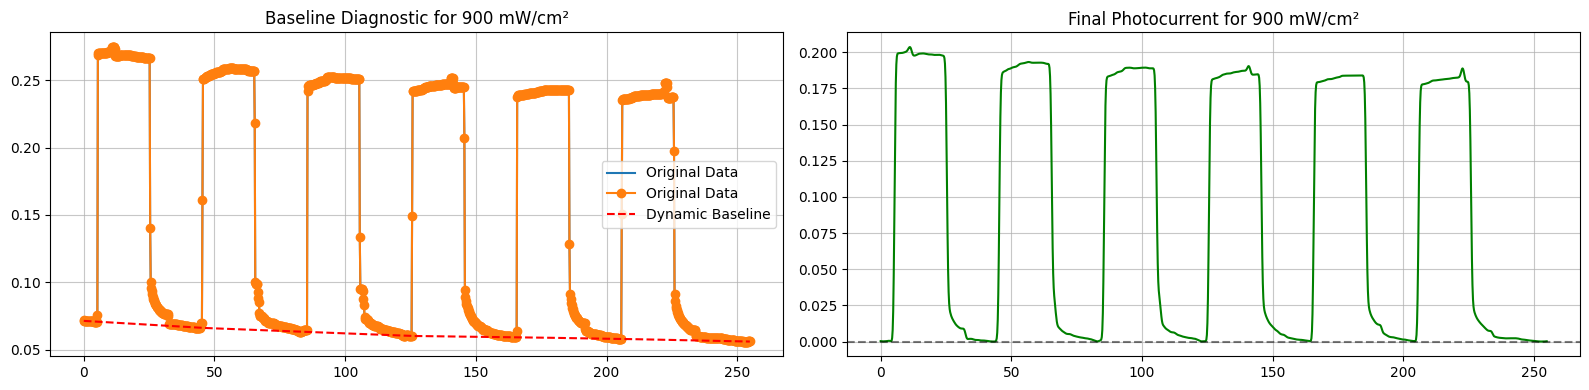


Processing: 1000 mW/cm²
225
--- Individual Plots for 1000 mW/cm² (Avg: 0.212 µA) ---


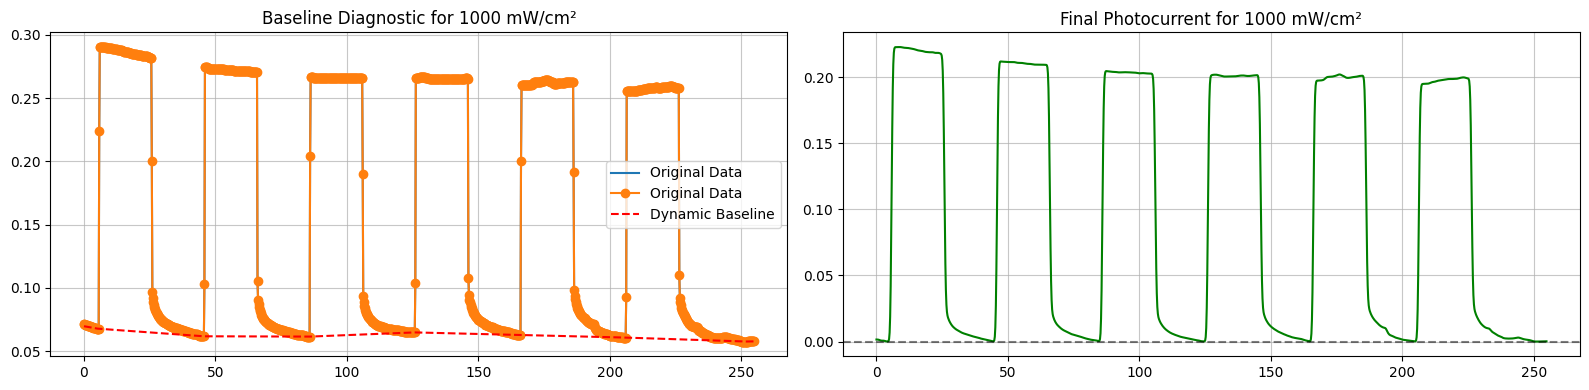

In [5]:
# --- 1. Configuration: Define what to compare ---
experiments_to_plot = {
    'Photocurrent_MIL100_100mW': '100 mW/cm²',
    'Photocurrent_MIL100_200mW': '200 mW/cm²',
    'Photocurrent_MIL100_300mW_2': '300 mW/cm²',
    'Photocurrent_MIL100_400mW': '400 mW/cm²',
    'Photocurrent_MIL100_500mW': '500 mW/cm²',
    'Photocurrent_MIL100_600mW': '600 mW/cm²',
    'Photocurrent_MIL100_700mW_2': '700 mW/cm²',
    'Photocurrent_MIL100_800mW_0_6v': '800 mW/cm²',
    'Photocurrent_MIL100_900mW_0_6v': '900 mW/cm²',
    'Photocurrent_MIL100_1000mW_0_6v': '1000 mW/cm²'}

    # 'Photocurrent_MIL100_1150mW_3' : '1150 mW/cm²',}
potential_to_plot = '0.6V'
start_time_s = 65
# output_folder = 'comparison_results'

smoothing_sigma = 1.5

# --- 2. Execution Loop ---
final_data_for_overlay = {}
summary_data = {}
for experiment_name, clean_label in experiments_to_plot.items():
    print(f"\n{'='*50}\nProcessing: {clean_label}\n{'='*50}")
    original_df = data_by_potential[experiment_name][potential_to_plot]
    
    df_processed, avg_photocurrent = process_photocurrent_robust(original_df,start_time_s=start_time_s,
        smoothing_sigma=2,
        hampel_window_s=1.5,
        hampel_nsigmas=.1,
        min_dark_gap_s=45,
        anchor_quantile=0.10,
        anchor_halfwin_s=2.0,
        baseline_smoothing_sigma=1.0,
        light_on_quantile=0.80)
        
    summary_data[experiment_name] = avg_photocurrent
    final_data_for_overlay[experiment_name] = df_processed
    
    # --- Individual Plots ---
    fig,ax = plt.subplots(1,2,figsize=(16, 4))
    print(f"--- Individual Plots for {clean_label} (Avg: {avg_photocurrent:.3f} µA) ---")
    ax[0].plot(df_processed['Time_s'], df_processed['Current_uA_despiked'], label='Original Data')
    ax[0].plot(df_processed['Time_s'], df_processed['Current_uA_despiked'], label='Original Data',marker='o')
    ax[0].plot(df_processed['Time_s'], df_processed['Baseline'], color='red', linestyle='--', label='Dynamic Baseline')
    ax[0].set_title(f"Baseline Diagnostic for {clean_label}")
    ax[0].legend()
    ax[0].grid(True, alpha=0.7)

    ax[1].plot(df_processed['Time_s'], df_processed['Photocurrent_uA'], color='green', label='Net Photocurrent')
    ax[1].set_title(f"Final Photocurrent for {clean_label}")
    ax[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax[1].grid(True, alpha=0.7)

    plt.tight_layout()
    plt.show()

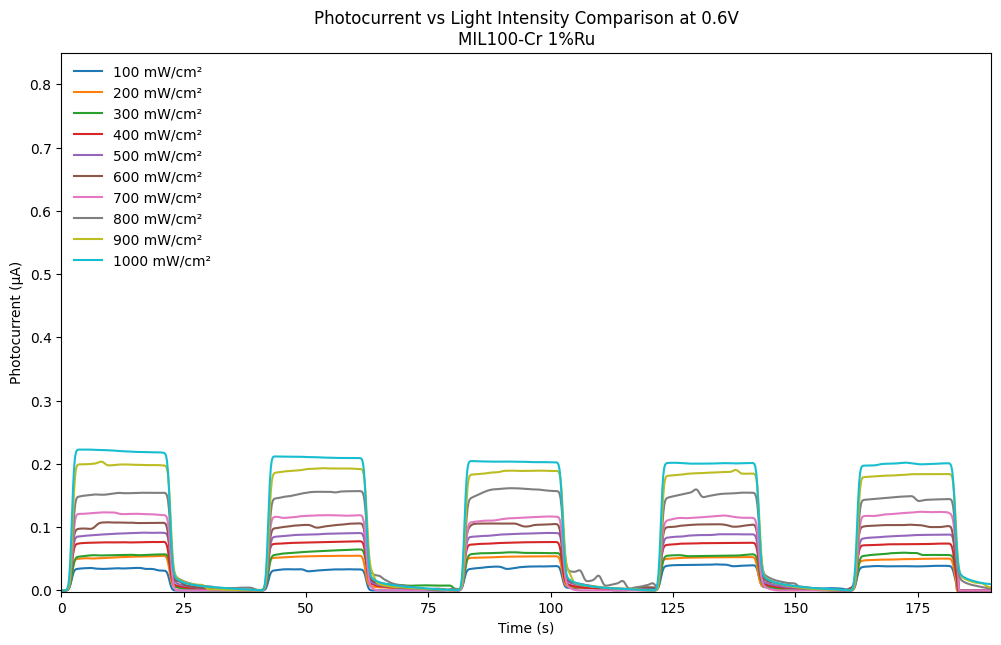

In [7]:
plt.figure(figsize=(12, 7))
ax = plt.gca()

aligned = {}
for name, df_final in final_data_for_overlay.items():
    df_aligned = align_window_and_pad(
        df_final,
        time_col="Time_s",
        y_col="Photocurrent_uA",
        baseline_window_s=5.0,
        threshold_frac=0.20,
        hold_s=0.30,
        prepad_s=2.0,       # “a bit of start”
        pad_to_xmax=165.0   # extend zeros so last pulse is followed by zeros to the end
    )
    aligned[name] = df_aligned
    ax.plot(df_aligned["Time_s"], df_aligned["Photocurrent_uA"], label=experiments_to_plot[name])

ax.set_title(f"Photocurrent vs Light Intensity Comparison at {potential_to_plot}\nMIL100-Cr 1%Ru")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Photocurrent (µA)")
ax.set_xlim(0, 190)
ax.set_ylim(-0.002, 0.85)
ax.legend(loc="upper left", frameon=False)


##### daqui pra baixo nao olhei


Processing: 100 mW/cm²
--- Individual Plots for 100 mW/cm² (Avg: 0.025 µA) ---


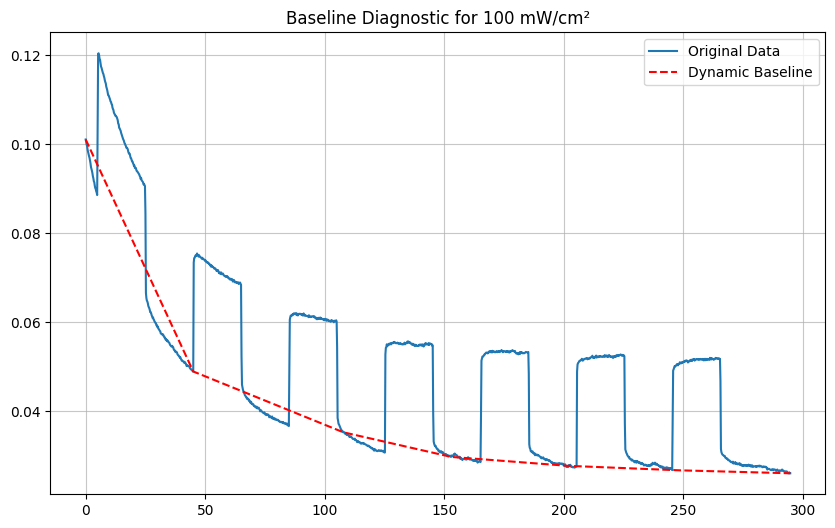

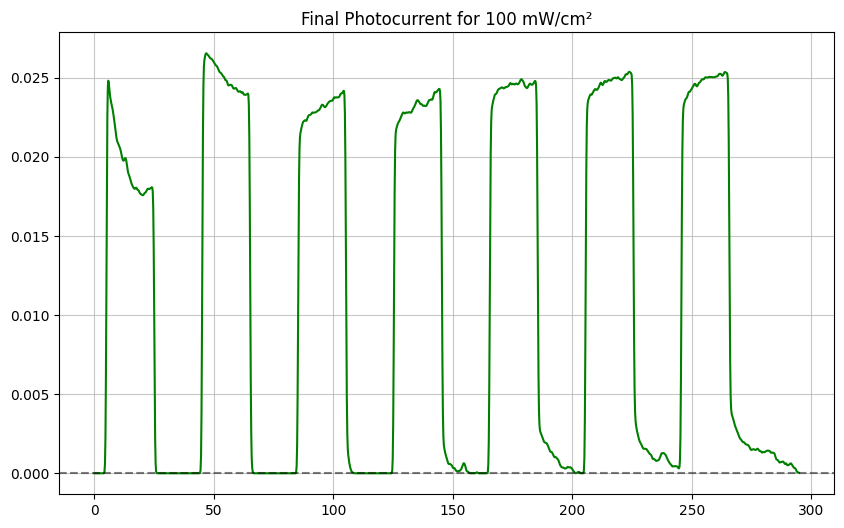


Processing: 200 mW/cm²
--- Individual Plots for 200 mW/cm² (Avg: 0.042 µA) ---


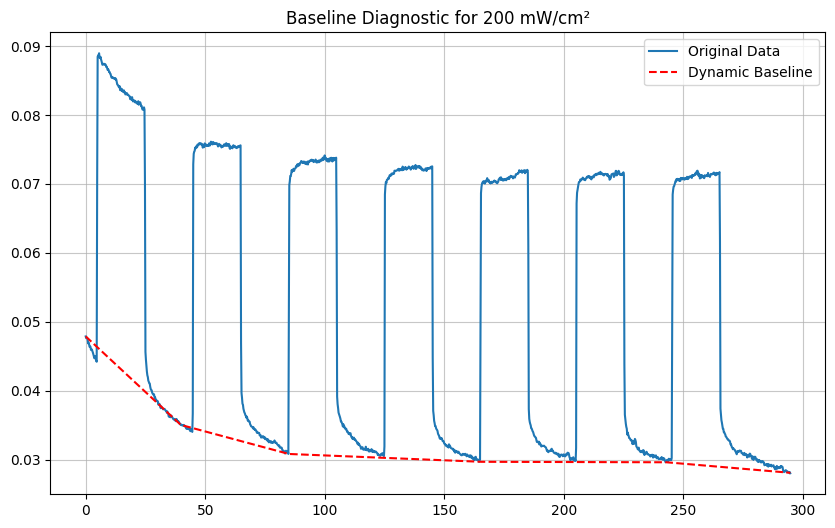

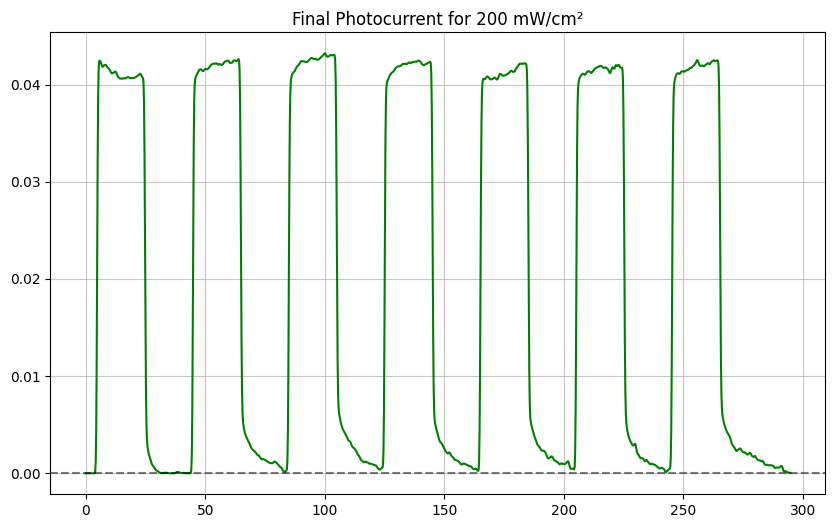


Processing: 300 mW/cm²
--- Individual Plots for 300 mW/cm² (Avg: 0.059 µA) ---


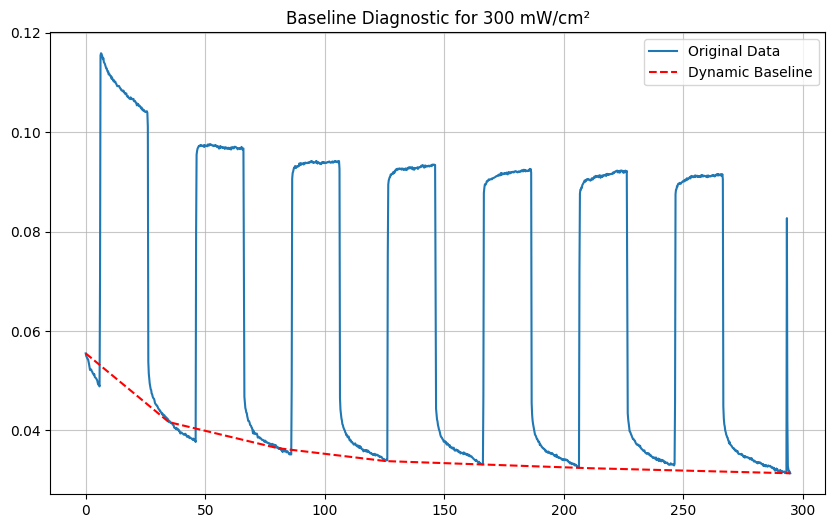

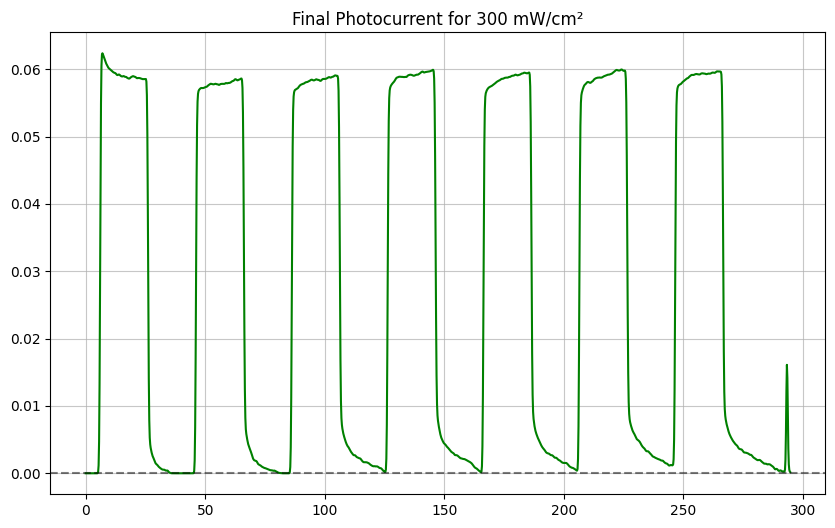


Processing: 400 mW/cm²
--- Individual Plots for 400 mW/cm² (Avg: 0.078 µA) ---


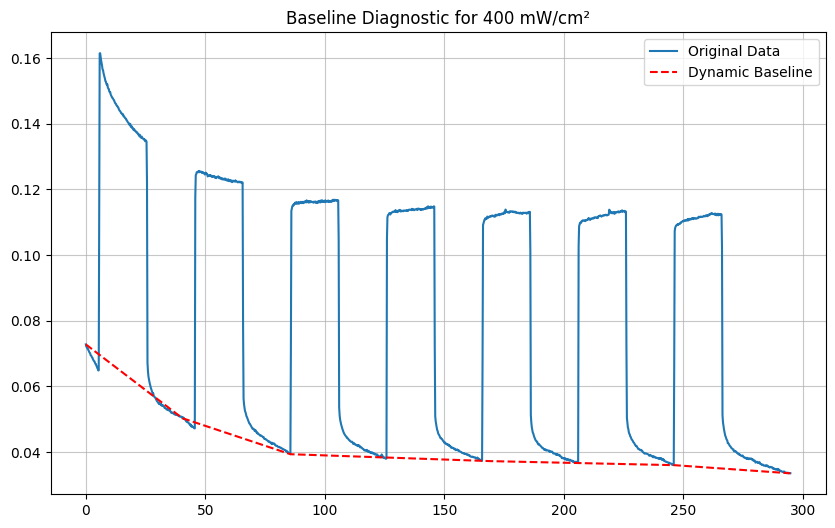

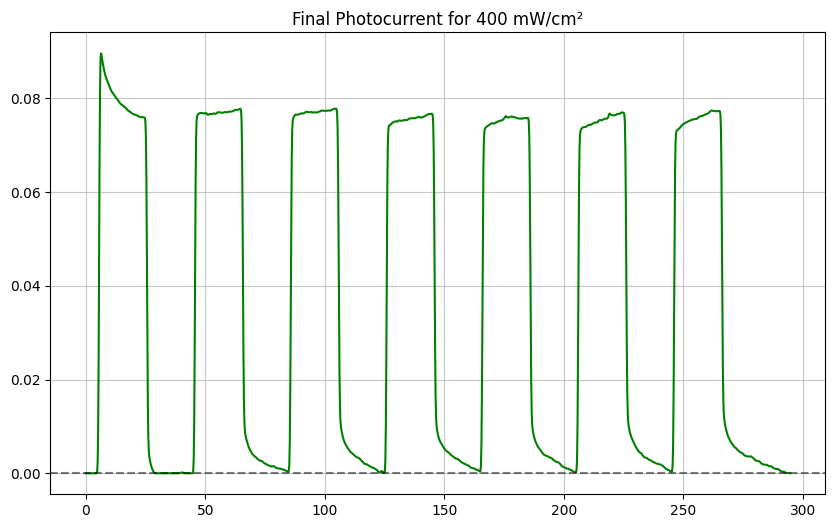


Processing: 500 mW/cm²
--- Individual Plots for 500 mW/cm² (Avg: 0.094 µA) ---


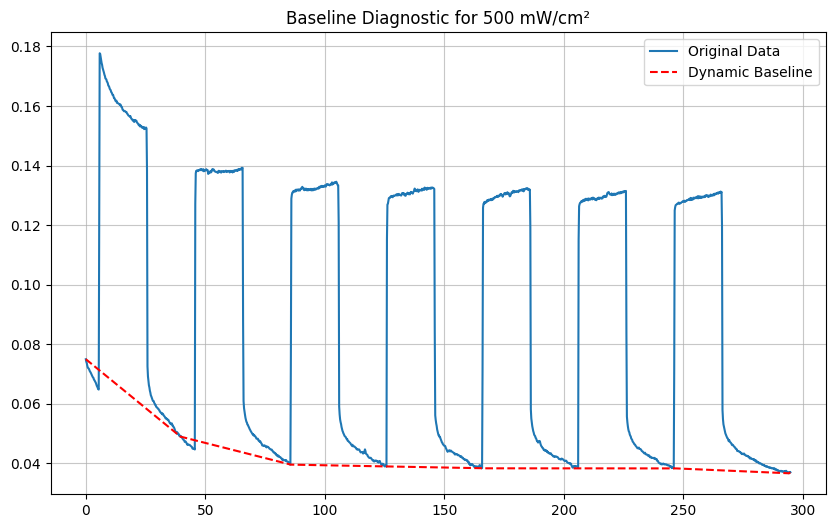

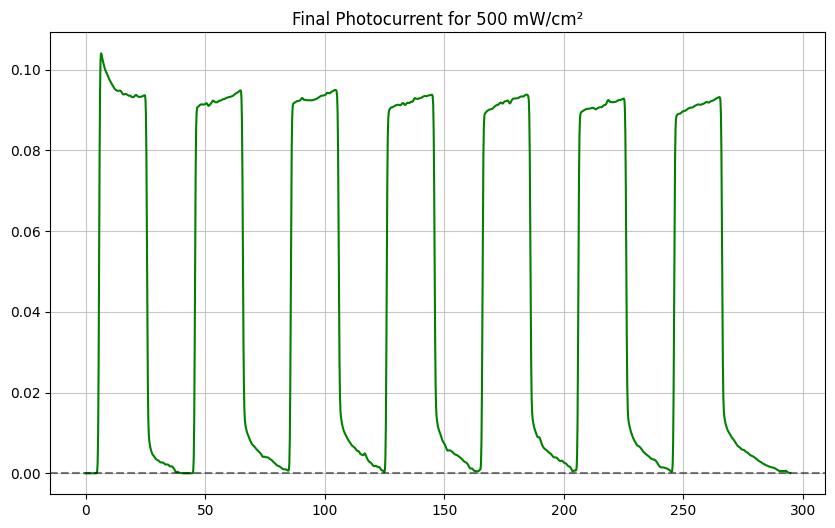


Processing: 600 mW/cm²
--- Individual Plots for 600 mW/cm² (Avg: 0.112 µA) ---


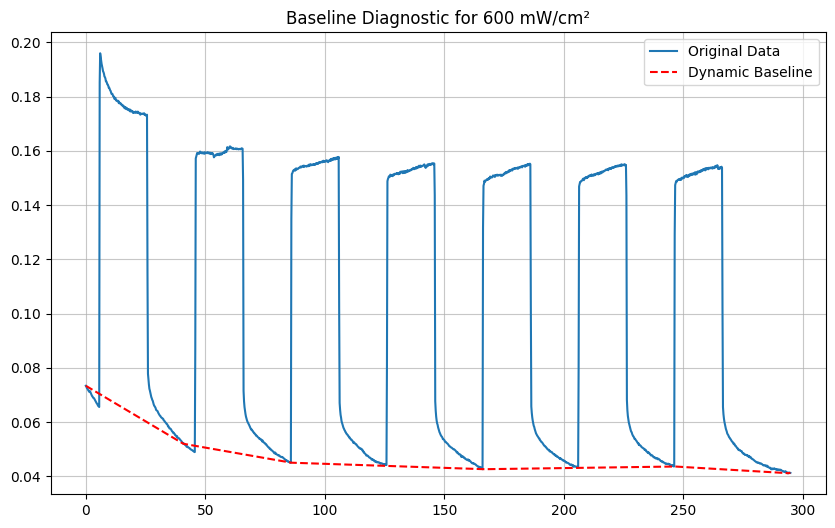

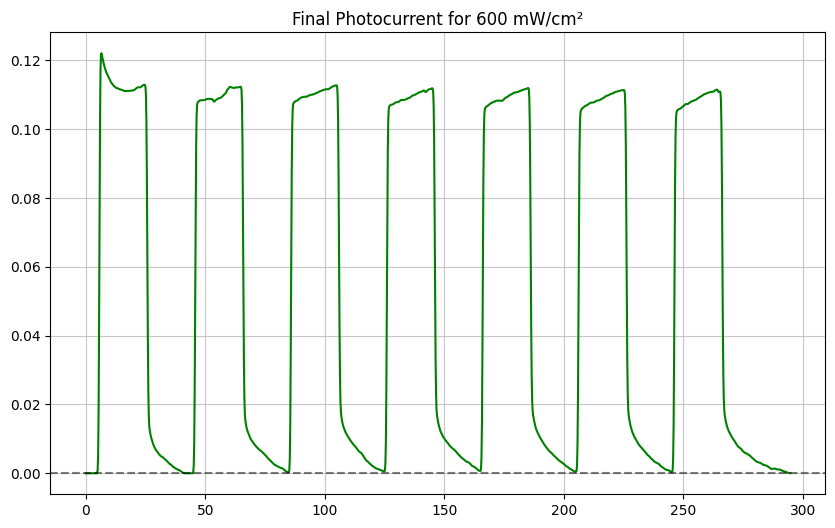


Processing: 700 mW/cm²
--- Individual Plots for 700 mW/cm² (Avg: 0.131 µA) ---


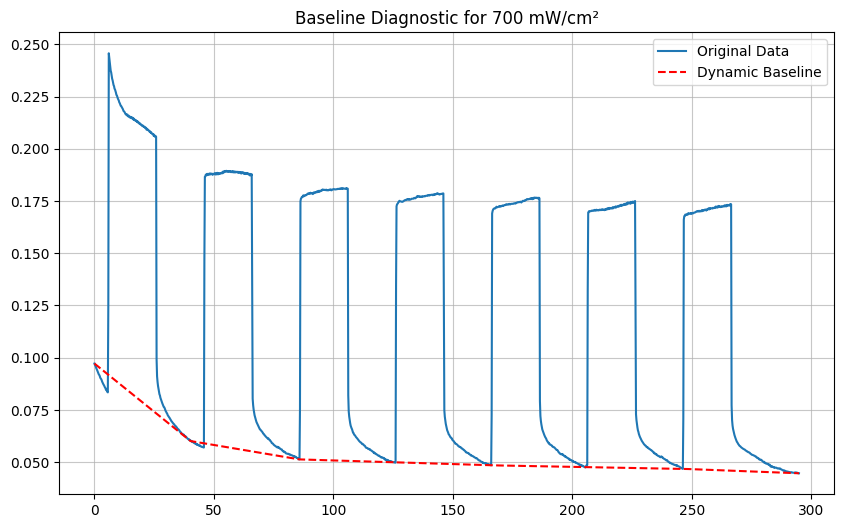

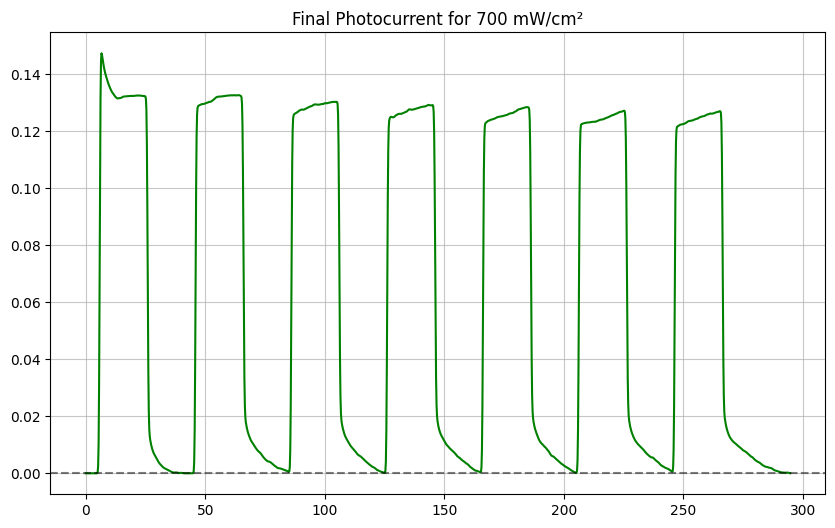


Processing: 800 mW/cm²
--- Individual Plots for 800 mW/cm² (Avg: 0.158 µA) ---


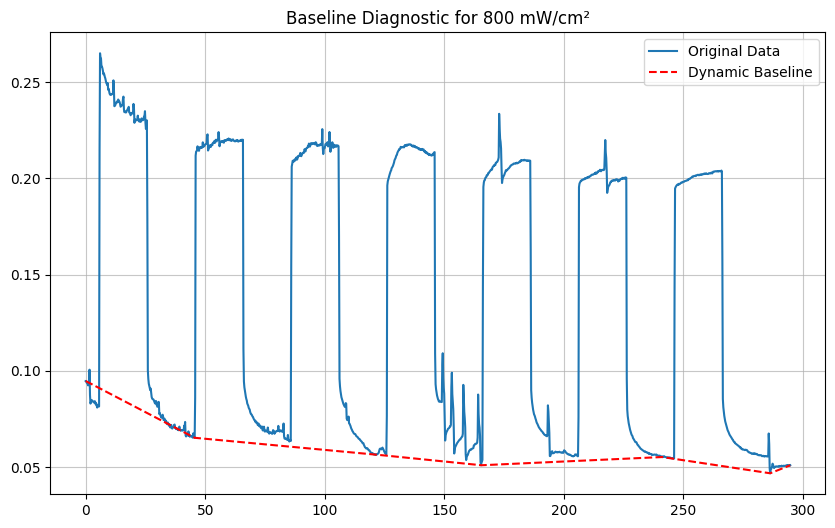

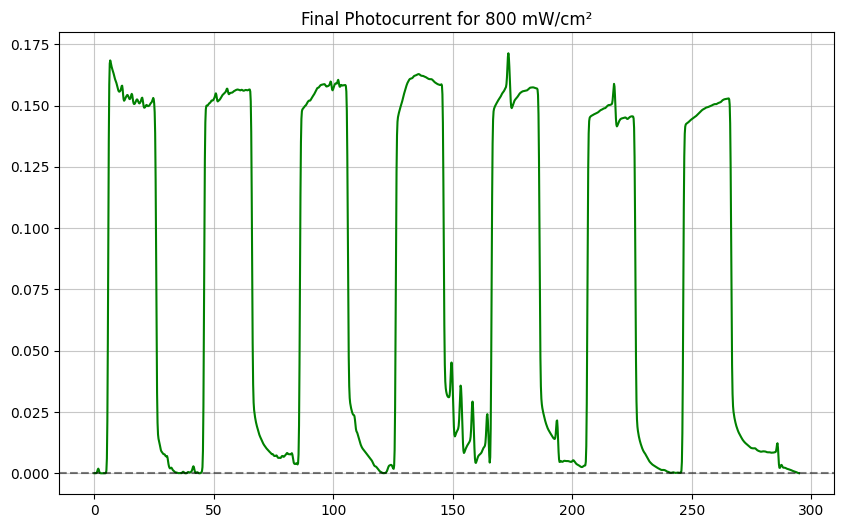


Processing: 900 mW/cm²
--- Individual Plots for 900 mW/cm² (Avg: 0.199 µA) ---


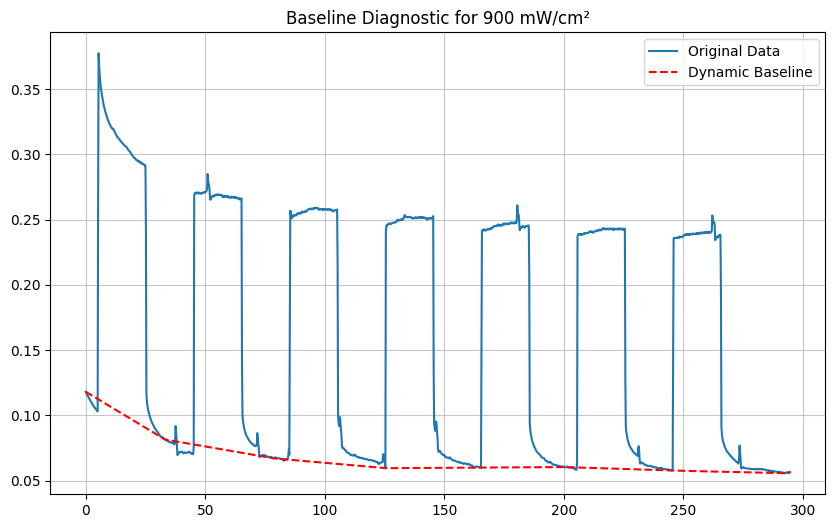

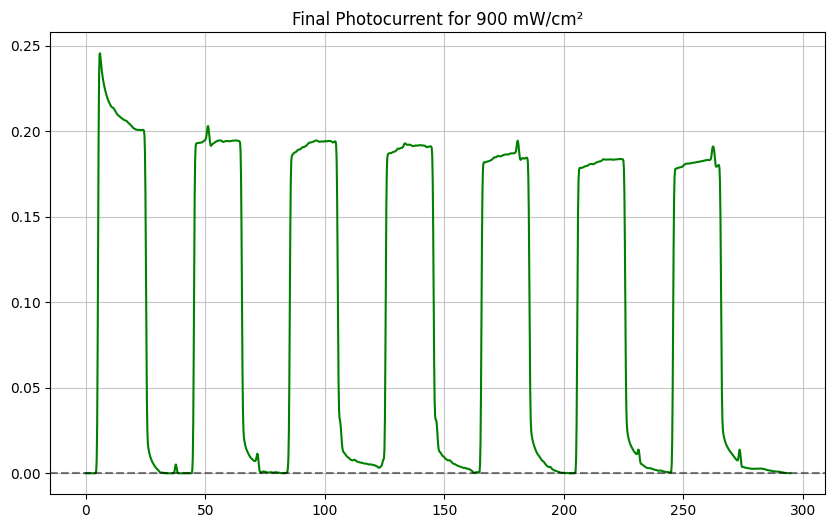


Processing: 1000 mW/cm²
--- Individual Plots for 1000 mW/cm² (Avg: 0.220 µA) ---


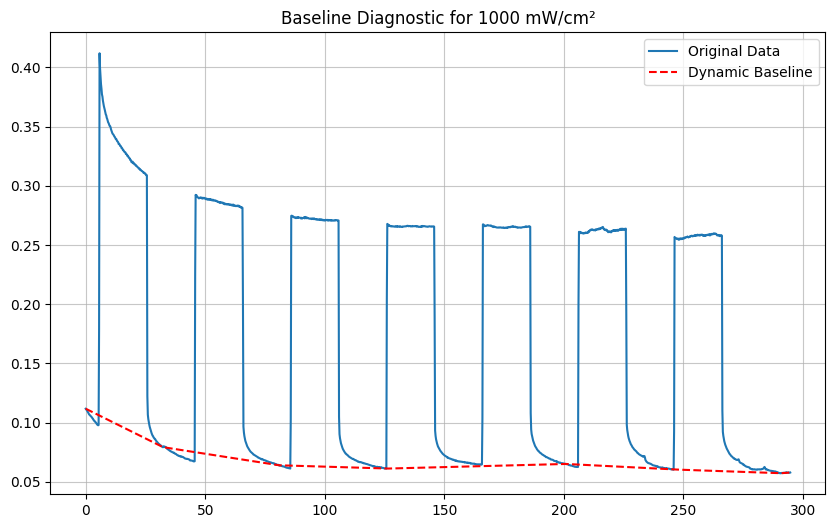

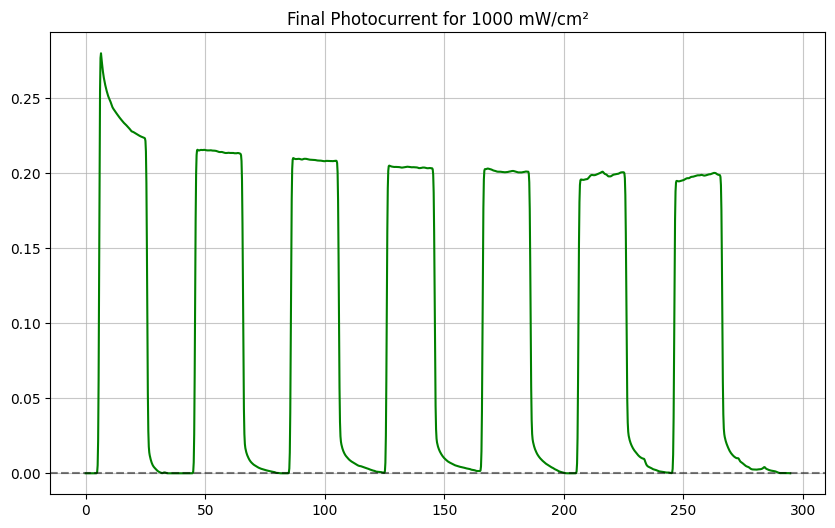


Processing: 1150 mW/cm²
--- Individual Plots for 1150 mW/cm² (Avg: 0.221 µA) ---


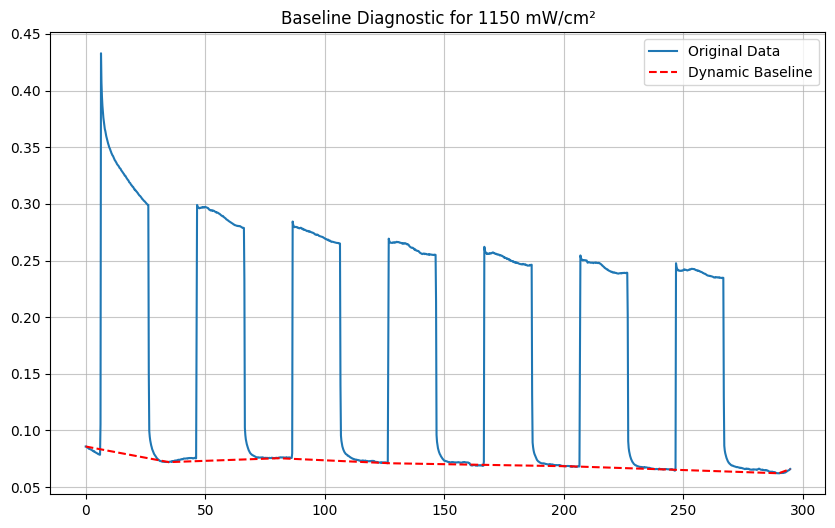

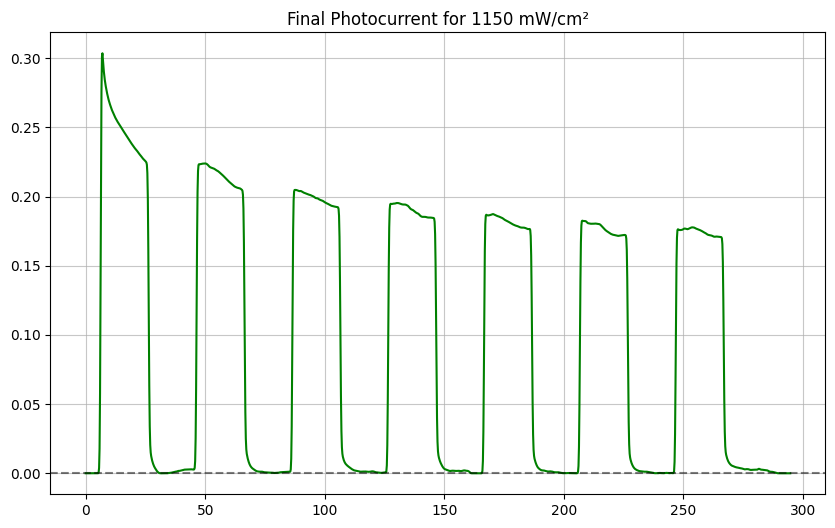


Creating Final Comparison Files


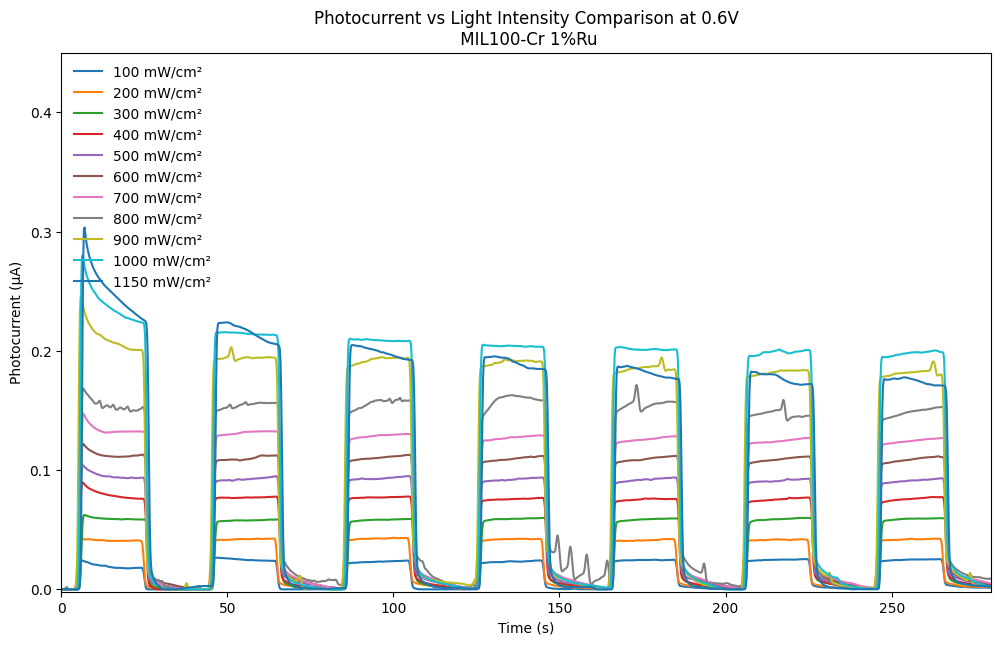

In [141]:
# --- 1. Configuration: Define what to compare ---
experiments_to_plot = {
    'Photocurrent_MIL100_100mW_0_6v': '100 mW/cm²',
    'Photocurrent_MIL100_200mW_0_6v': '200 mW/cm²',
    'Photocurrent_MIL100_300mW_0_6v': '300 mW/cm²',
    'Photocurrent_MIL100_400mW_0_6v': '400 mW/cm²',
    'Photocurrent_MIL100_500mW_0_6v': '500 mW/cm²',
    'Photocurrent_MIL100_600mW_0_6v': '600 mW/cm²',
    'Photocurrent_MIL100_700mW_0_6v': '700 mW/cm²',
    'Photocurrent_MIL100_800mW_0_6v': '800 mW/cm²',
    'Photocurrent_MIL100_900mW_0_6v': '900 mW/cm²',
    'Photocurrent_MIL100_1000mW_0_6v': '1000 mW/cm²',
    'Photocurrent_MIL100_1150mW_0_6v_2': '1150 mW/cm²',

 
}
potential_to_plot = '0.6V'
start_time_s = 25
output_folder = 'comparison_results'

# ⭐️ --- Change the smoothing intensity here --- ⭐️
# A higher number means more smoothing. 0 disables it.
smoothing_sigma = 1.5

# --- 2. Execution Loop ---
final_data_for_overlay = {}
summary_data = {}
for experiment_name, clean_label in experiments_to_plot.items():
    print(f"\n{'='*50}\nProcessing: {clean_label}\n{'='*50}")
    try:
        original_df = data_by_potential[experiment_name][potential_to_plot]
        
        # Call the processing function
        df_processed, avg_photocurrent = process_photocurrent(
            original_df,
            start_time_s=start_time_s,
            smoothing_sigma=smoothing_sigma
        )
        
        if df_processed is None:
            print(f"⚠️ WARNING: No data for {clean_label} in the given time range. Skipping.")
            continue
            
        summary_data[experiment_name] = avg_photocurrent
        final_data_for_overlay[experiment_name] = df_processed
        
        # --- Individual Plots ---
        print(f"--- Individual Plots for {clean_label} (Avg: {avg_photocurrent:.3f} µA) ---")
        plt.figure(figsize=(10, 6)); plt.plot(df_processed['Time_s'], df_processed['Current_uA'], label='Original Data'); plt.plot(df_processed['Time_s'], df_processed['Baseline'], color='red', linestyle='--', label='Dynamic Baseline'); plt.title(f"Baseline Diagnostic for {clean_label}"); plt.legend(); plt.grid(True, alpha=0.7); plt.show()
        plt.figure(figsize=(10, 6)); plt.plot(df_processed['Time_s'], df_processed['Photocurrent_uA'], color='green', label='Net Photocurrent'); plt.title(f"Final Photocurrent for {clean_label}"); plt.axhline(y=0, color='black', linestyle='--', alpha=0.5); plt.grid(True, alpha=0.7); plt.show()

    except KeyError:
        print(f"❌ ERROR: Could not find data for '{experiment_name}' at '{potential_to_plot}'. Skipping.")
    except Exception as e:
        print(f"An unexpected error occurred with {experiment_name}: {e}")

# --- 3. Final Comparison Plot and Saving ---
if final_data_for_overlay:
    print(f"\n{'='*50}\nCreating Final Comparison Files\n{'='*50}")
    plt.figure(figsize=(12, 7))
    for experiment_name, df_final in final_data_for_overlay.items():
        clean_label = experiments_to_plot[experiment_name]
        plt.plot(df_final['Time_s'], df_final['Photocurrent_uA'], label=clean_label)
        avg_current = summary_data[experiment_name]
        line_color = plt.gca().lines[-1].get_color()
        x_end = df_final['Time_s'].max()
        y_end = df_final['Photocurrent_uA'].max()
        plt.xlim(0, 280)
        plt.ylim(0, 0.45)
# --- NEW: Add non-overlapping annotations ---
    # Get the plot's axis limits to position the text
    x_max = plt.xlim()[1]
    y_min, y_max = plt.ylim()
    
    # Define a starting position and vertical step for the text stack
    y_position_start = y_max * 0.95 # Start X% of the way up the plot
    x_position_start = x_max * 0.98 # Start X% of the way up the plot
    y_step = y_max * 0.08         # Step down by 8% of the plot height for each label

    # Loop through the experiments again to add the text
    for i, experiment_name in enumerate(final_data_for_overlay.keys()):
        clean_label = experiments_to_plot[experiment_name]
        avg_current = summary_data[experiment_name]
        line_color = plt.gca().lines[i].get_color() # Get the color of the i-th line
        
        # Create the text string
        annotation_text = f"{clean_label}: {(avg_current * 1000):.1f} nA"
        
        # # Place the text in a neat stack on the right side
        # plt.text(x_position_start, y_position_start - (i * y_step), annotation_text,
        #          color=line_color,
        #          ha='right', # Horizontally align to the right
        #          va='top',   # Vertically align to the top
        #          weight='bold',
        #          fontsize=10)

    plt.title(f"Photocurrent vs Light Intensity Comparison at {potential_to_plot}\n MIL100-Cr 1%Ru")
    plt.xlabel("Time (s)")
    plt.ylabel("Photocurrent (µA)")
    plt.ylim(-0.002, None)
    plt.xlim(0, None)
    plt.legend(loc='upper left', frameon=False)

# os.makedirs(output_folder, exist_ok=True)
# clean_potential_name = potential_to_plot.replace('.', 'p')
# comparison_filepath = os.path.join(output_folder, f"MIL100In-Comparison_at_{clean_potential_name}_2.tiff")
# plt.savefig(comparison_filepath, dpi=300, bbox_inches='tight')
# print(f"✅ Final comparison plot saved to: {comparison_filepath}")
# plt.show()

# first_exp_name = list(final_data_for_overlay.keys())[0]
# common_time_axis = final_data_for_overlay[first_exp_name]['Time_s']
# df_for_csv = pd.DataFrame({'Time (s)': common_time_axis})
# for experiment_name, df_final in final_data_for_overlay.items():
#     clean_name = experiments_to_plot[experiment_name]
#     interpolated_current = np.interp(common_time_axis, df_final['Time_s'], df_final['Photocurrent_uA'])
#     df_for_csv[f'{clean_name} (uA)'] = interpolated_current
# comparison_csv_filepath = os.path.join(output_folder, f"MIL100In-Comparison_Data_at_{clean_potential_name}_2.csv")
# df_for_csv.to_csv(comparison_csv_filepath, index=False, float_format='%.6f')
# print(f"✅ Final comparison data saved to: {comparison_csv_filepath}")

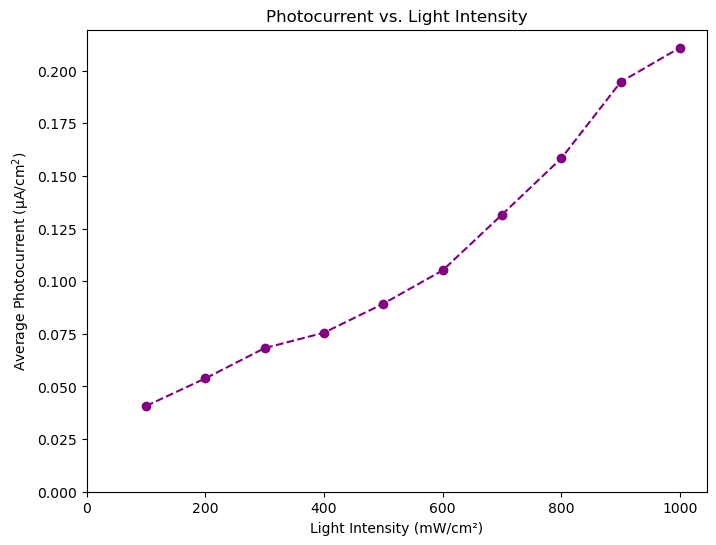

In [31]:
# --- New Cell: Summary Plot of Average Photocurrent vs. Light Intensity ---
# --- 1. Extract Data for the New Plot ---
power_values = []
current_values = []

# Loop through the summary data from the previous cell
for experiment_name, avg_current in summary_data.items():
    # Get the clean label (e.g., '300 mW/cm²') from your config
    clean_label = experiments_to_plot[experiment_name]
    
    # Use a regular expression to find the first number in the label
    match = re.search(r'(\d+\.?\d*)', clean_label)
    
    if match:
        power = float(match.group(1))
        power_values.append(power)
        current_values.append(avg_current)
    else:
        print(f"⚠️ Warning: Could not extract power value from '{clean_label}'. Skipping.")

# --- 2. Create the Summary Plot ---
if power_values: # Only plot if we successfully extracted data
    # Sort the data by power for a clean plot
    sorted_data = sorted(zip(power_values, current_values))
    power_sorted, current_sorted = zip(*sorted_data)
    
    plt.figure(figsize=(8, 6))
    
    plt.plot(power_sorted, current_sorted,
             marker='o',         # Add markers for each data point
             linestyle='--',    # Connect them with a dashed line
             color='purple')

    # --- Formatting ---
    plt.title('Photocurrent vs. Light Intensity')
    plt.xlabel('Light Intensity (mW/cm²)')
    plt.ylabel('Average Photocurrent (µA/cm$^2$)')
    plt.grid(False)
    
    # Optional: Start axes at zero
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    
    plt.show()
else:
    print("❌ No data was extracted to create the summary plot.")

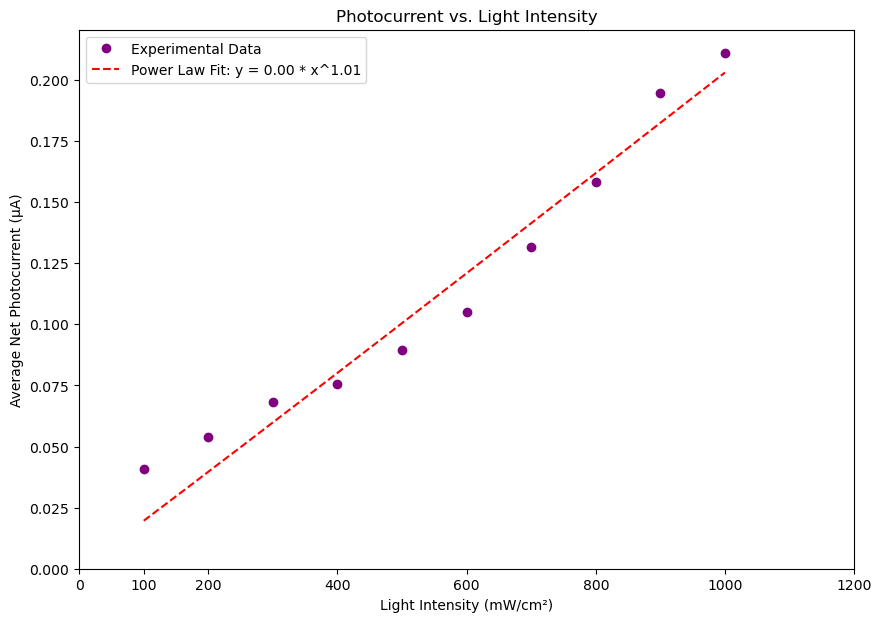

In [32]:
# --- 1. Define the function for the exponential fit ---
# A power-law function (y = a * x^b) is common for this analysis.
def power_law(x, a, b):
    return a * np.power(x, b)

# --- 2. Extract Data for the Plot ---
power_values = []
current_values = []
for experiment_name, avg_current in summary_data.items():
    clean_label = experiments_to_plot[experiment_name]
    match = re.search(r'(\d+\.?\d*)', clean_label)
    if match:
        power_values.append(float(match.group(1)))
        current_values.append(avg_current)

# --- 3. Create the Plot and Perform the Fit ---
if power_values:
    sorted_data = sorted(zip(power_values, current_values))
    power_sorted, current_sorted = zip(*sorted_data)
    
    # --- Perform the curve fit ---
    # Use curve_fit to find the best 'a' and 'b' parameters
    try:
        params, covariance = curve_fit(power_law, power_sorted, current_sorted)
        a_fit, b_fit = params
        fit_successful = True
    except RuntimeError:
        print("⚠️ Warning: Could not find a good exponential fit for this data.")
        fit_successful = False

    plt.figure(figsize=(10, 7))
    
    # Plot the original data as points
    plt.plot(power_sorted, current_sorted,
             marker='o',
             linestyle='none', # No line connecting the raw data points
             label='Experimental Data',
             color='purple')

    # Plot the fit line if successful
    if fit_successful:
        x_fit = np.linspace(min(power_sorted), max(power_sorted), 200)
        y_fit = power_law(x_fit, a_fit, b_fit)
        fit_label = f'Power Law Fit: y = {a_fit:.2f} * x^{b_fit:.2f}'
        plt.plot(x_fit, y_fit,
                 linestyle='--',
                 color='red',
                 label=fit_label)

    # --- Formatting ---
    plt.title('Photocurrent vs. Light Intensity')
    plt.xlabel('Light Intensity (mW/cm²)')
    plt.ylabel('Average Net Photocurrent (µA)')
    plt.legend()
    
    # --- NEW: Ensure '100' is an x-axis tick ---
    # Get the current ticks and add 100 to the list
    current_ticks = plt.gca().get_xticks()
    new_ticks = np.append(current_ticks, 100)
    new_ticks = np.unique(np.sort(new_ticks)) # Sort and remove duplicates
    plt.xticks(new_ticks)
    
    # --- NEW: Grid is removed by not calling plt.grid() ---
    
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.show()
else:
    print("❌ No data was extracted to create the summary plot.")

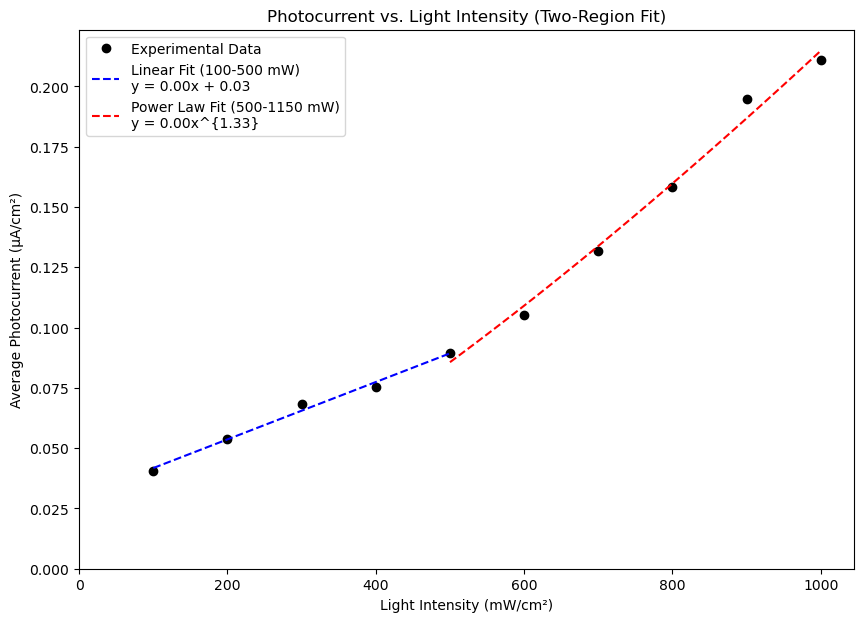

In [33]:

# --- 1. Define the function for the exponential fit ---
def power_law(x, a, b):
    return a * np.power(x, b)

# --- 2. Extract Data for the Plot ---
power_values = []
current_values = []
for experiment_name, avg_current in summary_data.items():
    clean_label = experiments_to_plot[experiment_name]
    match = re.search(r'(\d+\.?\d*)', clean_label)
    if match:
        power_values.append(float(match.group(1)))
        current_values.append(avg_current)

# --- 3. Create the Plot and Perform the Fits ---
if power_values:
    # --- Convert to NumPy arrays and sort the data ---
    power_np = np.array(power_values)
    current_np = np.array(current_values)
    sort_indices = np.argsort(power_np)
    power_sorted = power_np[sort_indices]
    current_sorted = current_np[sort_indices]

    # --- Split data into two regions ---
    mask_linear = (power_sorted >= 100) & (power_sorted <= 500)
    x_linear, y_linear = power_sorted[mask_linear], current_sorted[mask_linear]

    mask_exp = (power_sorted >= 500) & (power_sorted <= 1150)
    x_exp, y_exp = power_sorted[mask_exp], current_sorted[mask_exp]

    plt.figure(figsize=(10, 7))
    
    # Plot the original experimental data as points
    plt.plot(power_sorted, current_sorted, marker='o', linestyle='none', label='Experimental Data', color='black')

    # --- Fit 1: Linear fit for 100-500 mW ---
    if len(x_linear) >= 2: # Need at least 2 points for a linear fit
        m, c = np.polyfit(x_linear, y_linear, 1)
        x_fit_linear = np.linspace(x_linear.min(), x_linear.max(), 100)
        y_fit_linear = m * x_fit_linear + c
        fit_label_linear = f'Linear Fit (100-500 mW)\ny = {m:.2f}x + {c:.2f}'
        plt.plot(x_fit_linear, y_fit_linear, linestyle='--', color='blue', label=fit_label_linear)
        
    # --- Fit 2: Exponential fit for 500-1150 mW ---
    if len(x_exp) >= 2: # Need at least 2 points for a curve fit
        try:
            params, _ = curve_fit(power_law, x_exp, y_exp)
            a, b = params
            x_fit_exp = np.linspace(x_exp.min(), x_exp.max(), 100)
            y_fit_exp = power_law(x_fit_exp, a, b)
            fit_label_exp = f'Power Law Fit (500-1150 mW)\ny = {a:.2f}x^{{{b:.2f}}}'
            plt.plot(x_fit_exp, y_fit_exp, linestyle='--', color='red', label=fit_label_exp)
        except RuntimeError:
            print("⚠️ Warning: Could not find a good exponential fit for the high-power region.")

    # --- Formatting ---
    plt.title('Photocurrent vs. Light Intensity (Two-Region Fit)')
    plt.xlabel('Light Intensity (mW/cm²)')
    plt.ylabel('Average Photocurrent (µA/cm²)')
    plt.legend()
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.show()
else:
    print("❌ No data was extracted to create the summary plot.")

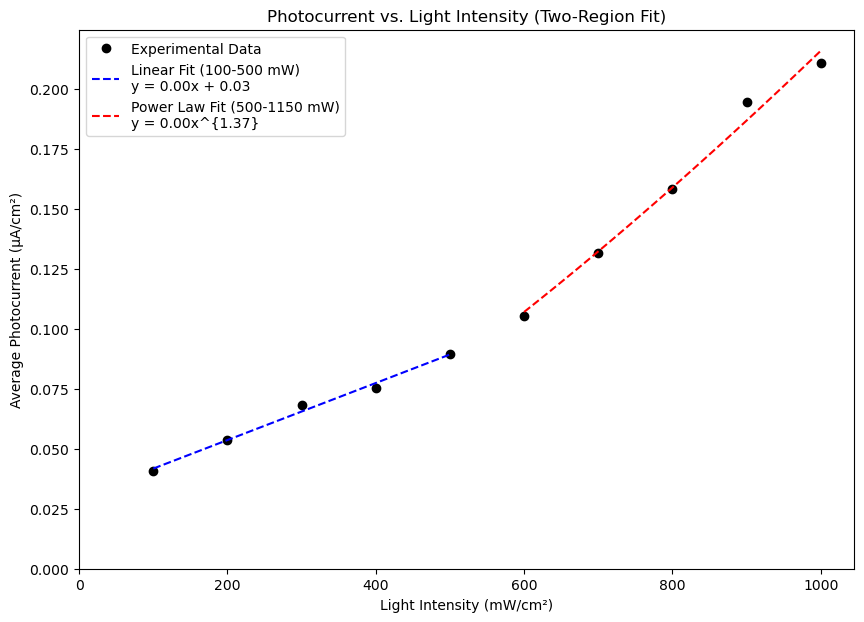

In [35]:

# --- 1. Define the function for the exponential fit ---
def power_law(x, a, b):
    return a * np.power(x, b)

# --- 2. Extract Data for the Plot ---
power_values = []
current_values = []
for experiment_name, avg_current in summary_data.items():
    clean_label = experiments_to_plot[experiment_name]
    match = re.search(r'(\d+\.?\d*)', clean_label)
    if match:
        power_values.append(float(match.group(1)))
        current_values.append(avg_current)

# --- 3. Create the Plot and Perform the Fits ---
if power_values:
    # --- Convert to NumPy arrays and sort the data ---
    power_np = np.array(power_values)
    current_np = np.array(current_values)
    sort_indices = np.argsort(power_np)
    power_sorted = power_np[sort_indices]
    current_sorted = current_np[sort_indices]

    # --- Split data into two regions ---
    mask_linear = (power_sorted >= 100) & (power_sorted <= 500)
    x_linear, y_linear = power_sorted[mask_linear], current_sorted[mask_linear]

    mask_exp = (power_sorted >= 600) & (power_sorted <= 1150)
    x_exp, y_exp = power_sorted[mask_exp], current_sorted[mask_exp]

    plt.figure(figsize=(10, 7))
    
    # Plot the original experimental data as points
    plt.plot(power_sorted, current_sorted, marker='o', linestyle='none', label='Experimental Data', color='black')

    # --- Fit 1: Linear fit for 100-500 mW ---
    if len(x_linear) >= 2: # Need at least 2 points for a linear fit
        m, c = np.polyfit(x_linear, y_linear, 1)
        x_fit_linear = np.linspace(x_linear.min(), x_linear.max(), 100)
        y_fit_linear = m * x_fit_linear + c
        fit_label_linear = f'Linear Fit (100-500 mW)\ny = {m:.2f}x + {c:.2f}'
        plt.plot(x_fit_linear, y_fit_linear, linestyle='--', color='blue', label=fit_label_linear)
        
    # --- Fit 2: Exponential fit for 500-1150 mW ---
    if len(x_exp) >= 2: # Need at least 2 points for a curve fit
        try:
            params, _ = curve_fit(power_law, x_exp, y_exp)
            a, b = params
            x_fit_exp = np.linspace(x_exp.min(), x_exp.max(), 100)
            y_fit_exp = power_law(x_fit_exp, a, b)
            fit_label_exp = f'Power Law Fit (500-1150 mW)\ny = {a:.2f}x^{{{b:.2f}}}'
            plt.plot(x_fit_exp, y_fit_exp, linestyle='--', color='red', label=fit_label_exp)
        except RuntimeError:
            print("⚠️ Warning: Could not find a good exponential fit for the high-power region.")

    # --- Formatting ---
    plt.title('Photocurrent vs. Light Intensity (Two-Region Fit)')
    plt.xlabel('Light Intensity (mW/cm²)')
    plt.ylabel('Average Photocurrent (µA/cm²)')
    plt.legend()
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.show()
else:
    print("❌ No data was extracted to create the summary plot.")

In [17]:
power_sorted, power_np

(array([ 100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,  900.,
        1000., 1150.]),
 array([ 100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,  900.,
        1000., 1150.]))